In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../../')])

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Manual setting of the basis

In this example, we show how to setup a user-defined basis. It is done here for the ocean, but the approach is the same for the other components. We will project the ocean equations on four modes proposed in

* S. Pierini. *Low-frequency variability, coherence resonance, and phase selection in a low-order model of the wind-driven ocean circulation.* Journal of Physical Oceanography, **41**(9):1585–1604, 2011. [doi:10.1175/JPO-D-10-05018.1](https://journals.ametsoc.org/doi/full/10.1175/JPO-D-10-05018.1).

* S. Vannitsem and L. De Cruz. *A 24-variable low-order coupled ocean–atmosphere model: OA-QG-WS v2*. Geoscientific Model Development, 7(2):649–662, 2014. [doi:10.5194/gmd-7-649-2014](https://doi.org/10.5194/gmd-7-649-2014).

These four modes are given by

* $\tilde\phi_1(x,y)=2 \, e^{−\alpha x} \sin(n x/2) \sin(y)$
* $\tilde\phi_2(x,y)=2 \, e^{−\alpha x} \sin(n x) \sin(y)$
* $\tilde\phi_3(x,y)=2 \, e^{−\alpha x} \sin(n x/2) \sin(2y)$
* $\tilde\phi_4(x,y)=2 \, e^{−\alpha x} \sin(n x) \sin(2y)$

This ocean is then connected to a channel atmosphere using a symbolic basis of functions.

## Modules import

Loading of some modules...

In [4]:
import sys, os, warnings

In [5]:
sys.path.extend([os.path.abspath('../')])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [7]:
np.random.seed(210217)

Importing the model's modules

In [8]:
from qgs.params.params import QgParams
from qgs.basis.base import SymbolicBasis
from qgs.inner_products.definition import StandardSymbolicInnerProductDefinition
from qgs.inner_products.symbolic import AtmosphericSymbolicInnerProducts, OceanicSymbolicInnerProducts
from qgs.tensors.qgtensor import QgsTensor
from qgs.functions.sparse_mul import sparse_mul3
from qgs.integrators.integrator import RungeKuttaIntegrator

and diagnostics

In [9]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

and some SymPy functions

In [10]:
from sympy import symbols, sin, exp, pi

## Systems definition

General parameters

In [11]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 100

number_of_trajectories = 1

Setting some model parameters and setting the atmosphere basis

In [12]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'n': 1.5})

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2, mode="symbolic")


Creating the ocean basis

In [13]:
ocean_basis = SymbolicBasis()
x, y = symbols('x y')  # x and y coordinates on the model's spatial domain
n, al = symbols('n al', real=True, nonnegative=True)  # aspect ratio and alpha coefficients
for i in range(1, 3):
    for j in range(1, 3):
        ocean_basis.functions.append(2 * exp(- al * x) * sin(j * n * x / 2) * sin(i * y))

Setting the value of the parameter α to a certain value (here α=1). Please note that the α is then an extrinsic parameter of the model that you have to specify through a substitution:

In [14]:
ocean_basis.substitutions.append((al, 1.))
ocean_basis.substitutions.append((n, model_parameters.scale_params.n))

Setting now the ocean basis

In [15]:
model_parameters.set_oceanic_modes(ocean_basis)

Additionally, for these particular ocean basis functions, a special inner product needs to be defined instead of the standard one proposed. We thus set up a new definition for the ocean component as in the publication linked above:


In [16]:
class UserInnerProductDefinition(StandardSymbolicInnerProductDefinition):

    def symbolic_inner_product(self, S, G, symbolic_expr=False, integrand=False):
        """Function defining the inner product to be computed symbolically:
        :math:`(S, G) = \\frac{n}{2\\pi^2}\\int_0^\\pi\\int_0^{2\\pi/n}  e^{2 \\alpha x} \\,  S(x,y)\\, G(x,y)\\, \\mathrm{d} x \\, \\mathrm{d} y`.

        Parameters
        ----------
        S: Sympy expression
            Left-hand side function of the product.
        G: Sympy expression
            Right-hand side function of the product.
        symbolic_expr: bool, optional
            If `True`, return the integral as a symbolic expression object. Else, return the integral performed symbolically.
        integrand: bool, optional
            If `True`, return the integrand of the integral and its integration limits as a list of symbolic expression object. Else, return the integral performed symbolically.

        Returns
        -------
        Sympy expression
            The result of the symbolic integration
        """
        expr = (n / (2 * pi ** 2)) * exp(2 * al * x) * S * G
        if integrand:
            return expr, (x, 0, 2 * pi / n), (y, 0, pi)
        else:
            return self.integrate_over_domain(self.optimizer(expr), symbolic_expr=symbolic_expr)




Finally setting some other model's parameters:

In [17]:
# Setting MAOOAM parameters according to the publication linked above
model_parameters.set_params({'kd': 0.029, 'kdp': 0.029, 'r': 1.0e-7,
                             'h': 136.5, 'd': 1.1e-7}) 
model_parameters.atemperature_params.set_params({'eps': 0.76, 'T0': 289.3,
                                                 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8, 'T0': 301.46})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [18]:
model_parameters.atemperature_params.set_insolation(103.3333, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)

Printing the model's parameters

In [19]:
model_parameters.print_params()

Qgs v0.9.9 parameters summary

General Parameters:
'dynamic_T': False,
'T4': False,
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.029  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.029  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 103.3333  [W][m^-2]  (spectral compone

We now construct the tendencies of the model by first constructing the ocean and atmosphere inner products objects. In addition, a inner product definition instance defined above must be passed to the ocean inner products object:

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ip = UserInnerProductDefinition()

    aip = AtmosphericSymbolicInnerProducts(model_parameters)
    oip = OceanicSymbolicInnerProducts(model_parameters, inner_product_definition=ip)


and finally we create manually the tendencies function, first by creating the tensor object:

In [21]:
aotensor = QgsTensor(model_parameters, aip, oip)

and then the Python-[Numba](https://numba.pydata.org/) callable for the model’s tendencies $\boldsymbol{f}$ : 

In [22]:
coo = aotensor.tensor.coords.T
val = aotensor.tensor.data

@njit
def f(t, x):
    xx = np.concatenate((np.full((1,), 1.), x))
    xr = sparse_mul3(coo, val, xx, xx)

    return xr[1:]

## Time integration

Defining an integrator

In [23]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors 

In [24]:
## Might take several minutes, depending on your cpu computational power.
ic = np.random.rand(model_parameters.ndim)*0.0001
integrator.integrate(0., 10000000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

Now integrate to obtain a trajectory on the attractor

In [25]:
integrator.integrate(0., 1000000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()

Plotting the result in 3D and 2D

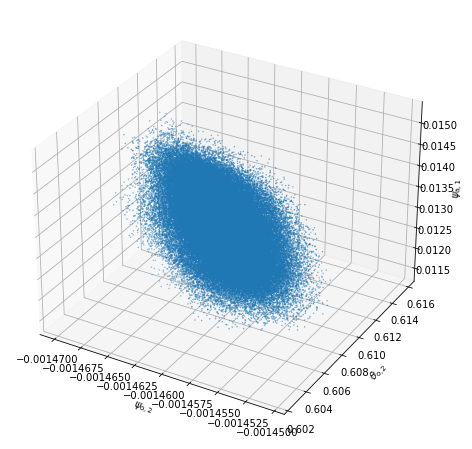

In [26]:
varx = 21
vary = 25
varz = 0

fig = plt.figure(figsize=(10, 8))
axi = fig.add_subplot(111, projection='3d')

axi.scatter(reference_traj[varx], reference_traj[vary], reference_traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

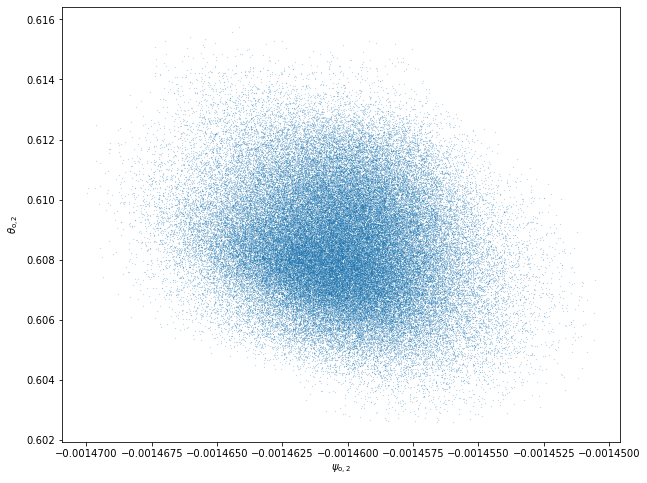

In [27]:
varx = 21
vary = 25
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

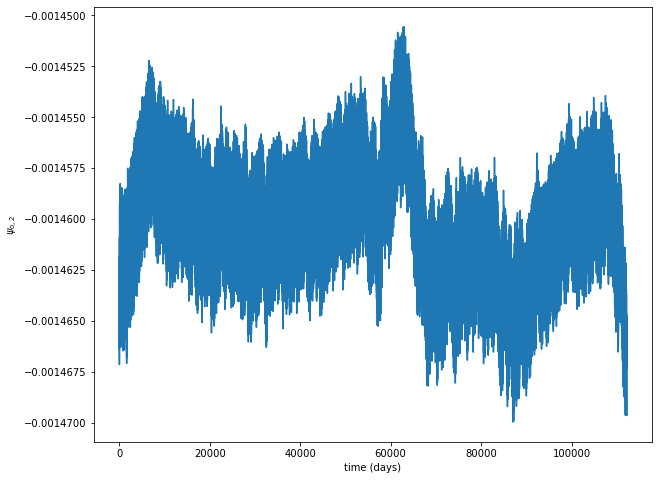

In [28]:
var = 21
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Showing the resulting fields (animation)

Here, we want to show that the diagnostics adapt to the manually set basis.

One can use objects called `Diagnostic` to plot movies of the model fields.
Here we show how to use them and plot the simultaneous time evolution of the variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\delta T_{{\rm o}, 2}$, with the corresponding atmospheric and oceanic streamfunctions and temperature at 500 hPa.

Creating the diagnostics (for field plots, we must specify the grid step):

* For the 500hPa geopotential height:

In [29]:
psi_a = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, delta_x=0.1, delta_y=0.1, geopotential=True)

* For the 500hPa atmospheric temperature:

In [30]:
theta_a = MiddleAtmosphericTemperatureDiagnostic(model_parameters, delta_x=0.1, delta_y=0.1)

* For the ocean streamfunction:

In [31]:
psi_o = OceanicLayerStreamfunctionDiagnostic(model_parameters, delta_x=0.1, delta_y=0.1, conserved=False)

* For the ocean temperature:

In [32]:
theta_o = OceanicLayerTemperatureDiagnostic(model_parameters, delta_x=0.1, delta_y=0.1)

* For the nondimensional variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\delta T_{{\rm o}, 2}$:

In [33]:
variable_nondim = VariablesDiagnostic([21, 25, 0], model_parameters, False)

* For the geopotential height difference between North and South:

In [34]:
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)


In [35]:
# setting also the background
background = VariablesDiagnostic([21, 25, 0], model_parameters, False)
background.set_data(reference_time, reference_traj)

Selecting a subset of the data to plot:

In [36]:
stride = 10
time = reference_time[10000:10000+5200*stride:stride]
traj = reference_traj[:, 10000:10000+5200*stride:stride]

Creating a multi diagnostic with both:

In [37]:
m = MultiDiagnostic(3,2)
m.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'moving-timeserie'})
m.add_diagnostic(variable_nondim, diagnostic_kwargs={'show_time':False, 'background': background, 'style':'3Dscatter'}, plot_kwargs={'ms': 0.2})
m.add_diagnostic(theta_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(theta_o, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_o, diagnostic_kwargs={'show_time':False})

m.set_data(time, traj)

and showing finally a movie:

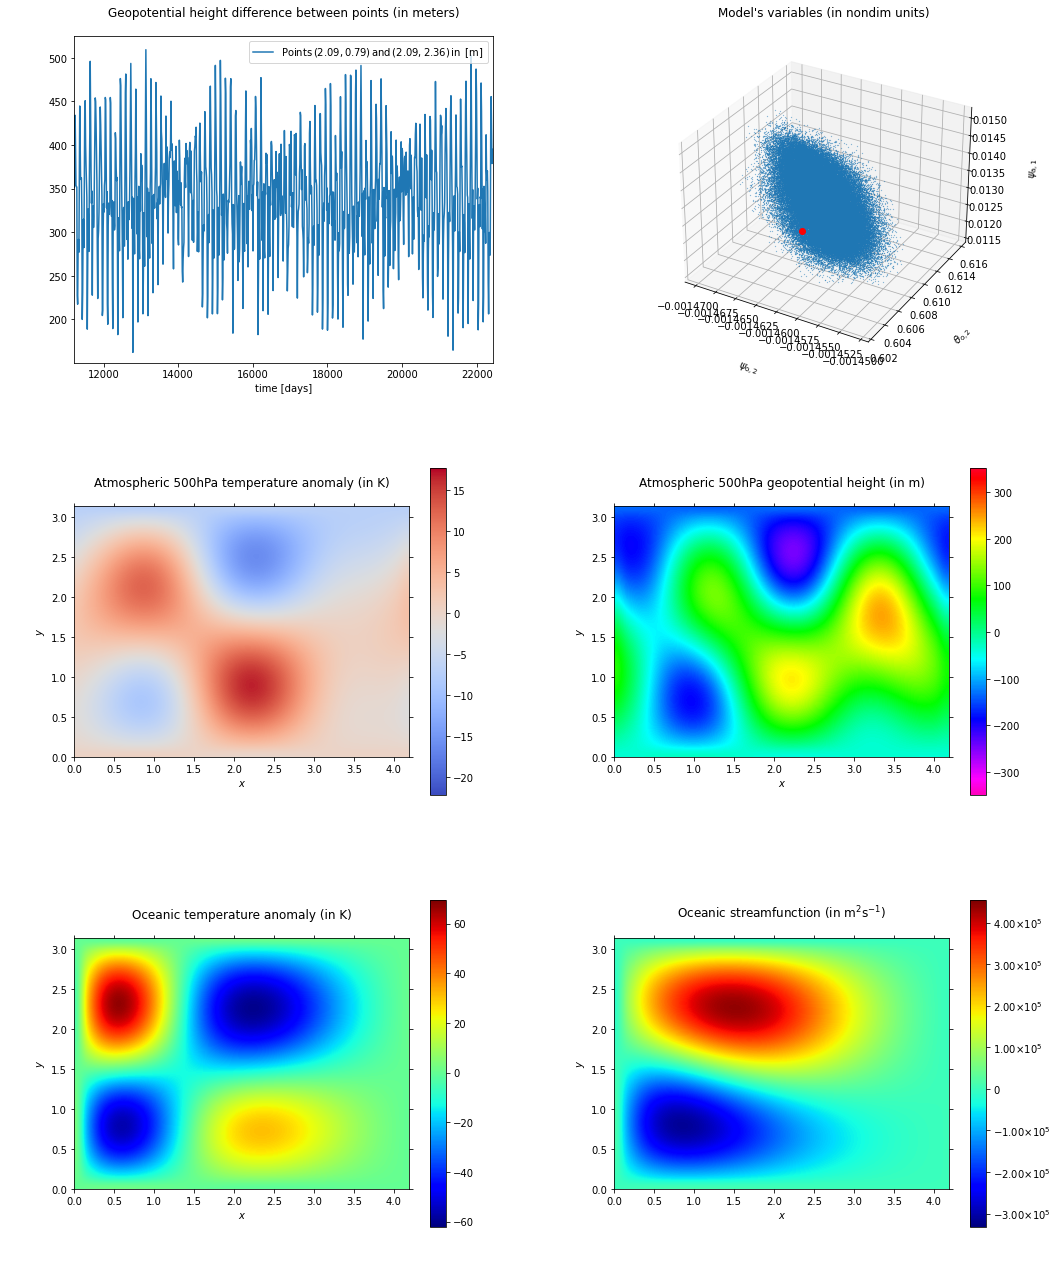

In [39]:
m.movie(figsize=(15,18), anim_kwargs={'interval': 100, 'frames':1000})